# Plotting histogram of total score

Check your placement for total scores.

In [ ]:
!pip install lxml ipywidgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

from hashlib import sha1
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def compute_hash(email):
    return sha1(email.lower().encode('utf-8')).hexdigest()

url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSNK_yGtELX1RJK1SSRl4xiUbD0XZMYS6uwHnybc7Mql-WMnMgO7hHSu59w-1cE7FeFZjkopbh684UE/pubhtml#'

list_df = pd.read_html(url, header=1, index_col=0)
for df in list_df[1:]:
    df.drop(index=np.NaN, inplace=True)
    df.reset_index(drop=True, inplace=True)

df_leaderboard = list_df[-1]


In [6]:
email_hash = ""
text_email = widgets.Text(
    placeholder='your email address',
    # description='Email:',
    disabled=False
)
text_hash = widgets.Text(
    placeholder='calculated hash',
    disabled=True
)
submit_button=widgets.Button(description='calculate hash',button_style='success')

def on_button_clicked(b):
  global email_hash
  email_hash = compute_hash(text_email.value)
  text_hash.placeholder = email_hash
  
display(widgets.HBox([text_email,submit_button, text_hash]))
submit_button.on_click(on_button_clicked)

In [ ]:
assert email_hash != '', "email hash is empty string"
assert email_hash not in df_leaderboard.email, f"hash '{email_hash}' not found in dataframe"

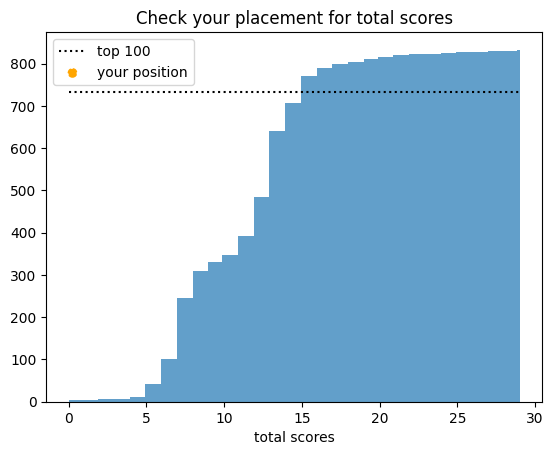

In [5]:
df_leaderboard.total.hist(bins=200, cumulative=True, alpha=.7)
plt.grid(False)

n = len(df_leaderboard)
total = df_leaderboard.loc[df_leaderboard.email==email_hash].total
plt.hlines(n-100, xmin=0, xmax=df_leaderboard.total.max(), color='black', linestyles=':', label='top 100')
plt.scatter(
    x=total.values,
    y=n-total.index.to_numpy(),
    color='orange', linestyles='--',
    marker='o',
    label='your position'
)
plt.xlabel('total scores')
plt.title('Check your placement for total scores')
plt.grid(False)
plt.legend()
plt.show()